**Proyecto Final** - Text Mining & Imagen Recongnition

#### **Felipe Escoto** - 23003984
#### **Jordi Chajon** - 23000477
#### **Angello Almengor** - 22003729

## Problema 1

Usando CoLab y expresiones regulares. Determine los 3 usuarios más populares dentro del dataset. Luego arme un corpus el cual contenga los siguientes elementos por cada usuario seleccionado:

Content: Tweet.
Metadata: ID, Timestamp, Length (este valor hay que calcularlo).

Posterior a tener sus 3 corpus creados, responda: A ¿Razónn por la que citan a ese usuario? para esto es necesario que extraiga el contexto de cada tweet y verifique cuales son las palabras que más rodean al nombre de usuario. Para extraer un contexto valido y debido a la naturaleza del tipo de datos que están disponibles en nuestro dataset le recomendamos seguir los siguientes pasos:

1. Remover stopwords.
2. Realizar stemming y lemmatización.
3. Mostrar un wordcloud con el top 10 para cada usuario.

In [ ]:
import pandas as pd
import spacy
import spacy.cli
import re

In [ ]:
spacy.cli.download("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("es_core_news_sm")
nlp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tw_str_path = "/content/drive/MyDrive/ProyectoFinal/tw_source.csv"
dataset = pd.read_csv(tw_str_path, encoding='latin1')
dataset.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
dataset.shape


(1599999, 6)

In [ ]:
column_names = ['query', 'id', 'timestamp', 'extra_column', 'username', 'tweet']
dataset.columns = column_names
dataset.head()


,query,id,timestamp,extra_column,username,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


# **Los 3 ususarios más populares**

In [ ]:
import re
from collections import Counter

# Buscar todas las menciones en los tweets usando expresiones regulares
mentions = dataset['tweet'].apply(lambda x: re.findall(r'@\w+', x))

# Aplanar la lista de menciones y contar las apariciones
flat_mentions = [mention for sublist in mentions for mention in sublist]
most_common_users = Counter(flat_mentions).most_common(3)

# Imprimir los 3 usuarios más citados
print("Los 3 usuarios más populares son:", most_common_users)


Los 3 usuarios más populares son: [('@mileycyrus', 4500), ('@tommcfly', 3887), ('@ddlovato', 3467)]


# **Corpus para los 3 usuarios más populares**

In [ ]:
# Crear una lista para almacenar los corpus de los 3 usuarios más populares
corpus = {}

for user, _ in most_common_users:
    # Filtrar los tweets que mencionan al usuario
    user_tweets = dataset[dataset['tweet'].str.contains(user, na=False)]

    # Crear el corpus con contenido y metadatos
    corpus[user] = user_tweets[['tweet', 'id', 'timestamp']].copy()

    # Calcular la longitud de cada tweet
    corpus[user]['length'] = corpus[user]['tweet'].apply(len)

# Visualizar el corpus de uno de los usuarios
print(corpus[most_common_users[0][0]].head())


                                                  tweet          id  \
1020  @mileycyrus hahaha dont be like that one time ...  1468063101   
2013  @mileycyrus i have the same problem, but it's ...  1468286517   
2072  @mileycyrus I guess counting sheep didn't work...  1468297110   
2079  @mileycyrus I would too if it meant spending a...  1468298918   
2155  @mileycyrus AWWW u seriously have the cutest d...  1468318249   

                         timestamp  length  
1020  Mon Apr 06 23:30:57 PDT 2009     107  
2013  Tue Apr 07 00:45:20 PDT 2009     137  
2072  Tue Apr 07 00:49:07 PDT 2009      72  
2079  Tue Apr 07 00:49:44 PDT 2009     100  
2155  Tue Apr 07 00:56:41 PDT 2009     112  


# **Extraer el contexto de los tweets y remover stopwords**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

# Asegúrate de descargar stopwords y lematizador si no lo has hecho
nltk.download('stopwords')
nltk.download('wordnet')

# Inicializamos el lematizador y el stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Añadimos stopwords adicionales específicas de Twitter
custom_stopwords = set(stopwords.words('english'))  # Lista base de nltk
custom_stopwords.update(['rt', 'via', 'http', 'https', 'co', 'u', 'amp'])  # Añadir palabras frecuentes de Twitter

# Función mejorada para eliminar stopwords, menciones y enlaces
def preprocess_text(text):
    # Eliminar menciones y enlaces
    text = re.sub(r'@\w+', '', text)  # Eliminar menciones (@usuario)
    text = re.sub(r'http\S+|www\S+', '', text)  # Eliminar URLs

    # Convertir a minúsculas y extraer solo palabras alfanuméricas
    words = re.findall(r'\b\w+\b', text.lower())

    # Remover stopwords personalizadas
    words = [word for word in words if word not in custom_stopwords]

    # Lematización
    words = [lemmatizer.lemmatize(word) for word in words]

    # Stemming (opcional, puedes quitarlo si prefieres solo lematización)
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Aplicar el procesamiento mejorado de texto a los corpus de cada usuario
for user in corpus:
    corpus[user]['processed_tweet'] = corpus[user]['tweet'].apply(preprocess_text)

# Visualizar el corpus procesado para un usuario
print(corpus[most_common_users[0][0]].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                  tweet          id  \
1020  @mileycyrus hahaha dont be like that one time ...  1468063101   
2013  @mileycyrus i have the same problem, but it's ...  1468286517   
2072  @mileycyrus I guess counting sheep didn't work...  1468297110   
2079  @mileycyrus I would too if it meant spending a...  1468298918   
2155  @mileycyrus AWWW u seriously have the cutest d...  1468318249   

                         timestamp  length  \
1020  Mon Apr 06 23:30:57 PDT 2009     107   
2013  Tue Apr 07 00:45:20 PDT 2009     137   
2072  Tue Apr 07 00:49:07 PDT 2009      72   
2079  Tue Apr 07 00:49:44 PDT 2009     100   
2155  Tue Apr 07 00:56:41 PDT 2009     112   

                                        processed_tweet  
1020  hahaha dont like one time ny got 30 min sleep ...  
2013  problem 4 43 let see count work 1234 56 57 58 ...  
2072              guess count sheep work hope get sleep  
2079         would meant spend day heaven w mom get see  
2155  

# **Crear un WordCloud para cada usuario**

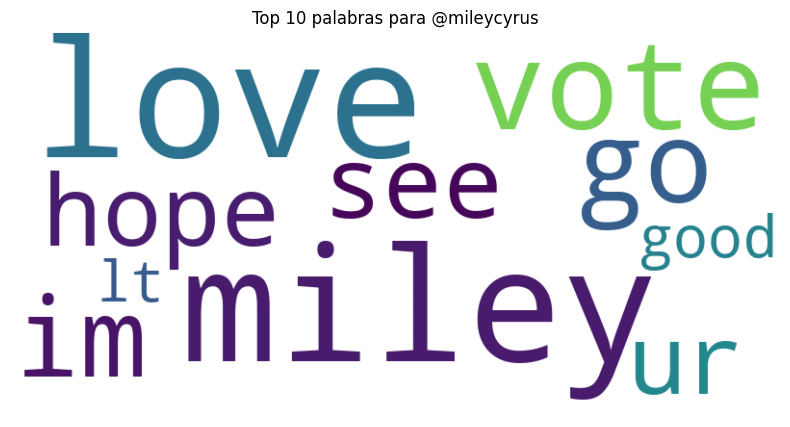

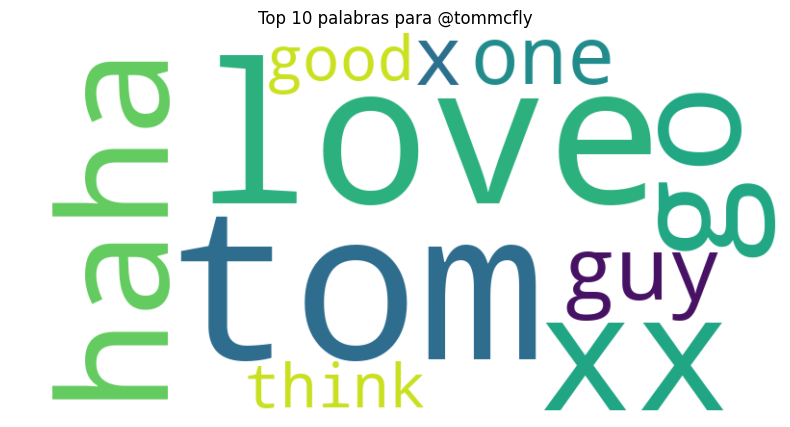

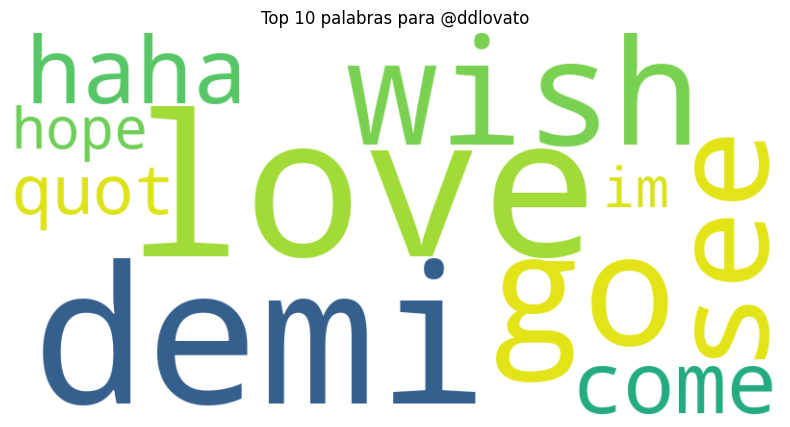

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Función para generar el wordcloud
def generate_wordcloud(user, corpus):
    all_text = ' '.join(corpus['processed_tweet'])
    wordcloud = WordCloud(width=800, height=400, max_words=10, background_color='white').generate(all_text)

    # Mostrar el WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Top 10 palabras para {user}")
    plt.show()

# Generar WordClouds para los 3 usuarios más populares
for user in most_common_users:
    generate_wordcloud(user[0], corpus[user[0]])
